In [27]:
import torch
from torch import nn, optim, no_grad
import numpy as np
import torchvision
import torchvision.transforms as tt
from tqdm import tqdm

import os
import matplotlib.pyplot as plt

In [7]:
os.getcwd()
data_path = f"{os.getcwd()}/data/"

# Import the dataset you want

Change the dimensions, etc.

In [8]:
train_transform = tt.Compose([
    tt.ToTensor(),
    tt.Resize(256),
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Resize(256),
])

dataset_train = torchvision.datasets.CIFAR100(data_path, 
                                        train = True, 
                                        download = True,
                                        transform=train_transform)
dataset_test_val = torchvision.datasets.CIFAR100(data_path, 
                                        train = False, 
                                        download = True,
                                        transform=test_transform)

dataset_val = list()
dataset_test = list()
for i, data in enumerate(dataset_test_val):
    if i < 1000:
        dataset_val.append(data)
    else:
        dataset_test.append(data)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /Users/m.goibert/Documents/Criteo/Projets_Recherche/General_learning_code/data/cifar-100-python.tar.gz to /Users/m.goibert/Documents/Criteo/Projets_Recherche/General_learning_code/data/
Files already downloaded and verified


# Use the pretrained model you want

In [9]:
model_pretrained = torchvision.models.resnet18(pretrained=True, progress=True)

In [10]:
class last_layer(nn.Module):
    def __init__(self):
        super(last_layer, self).__init__()
        self.fc = nn.Linear(1000, 100)
    
    def forward(self, x):
        x = self.fc(x)
        return x

last_layer_model = last_layer()

In [12]:
model = nn.Sequential(model_pretrained, last_layer_model)
model = model.float()

# Train your model

In [24]:
def compute_acc(model, dataset):
    correct = 0
    with no_grad():
        for i, (data, target) in enumerate(dataset):
            data = data.unsqueeze(0).float()
            target = torch.tensor(target).unsqueeze(0)
            pred = model(data).argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(dataset)
    return acc

def fit(model, epochs, dataset, dataset_val, model_path=f"{os.getcwd()}/trained_models/"):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=10, verbose=True, factor=0.5)
    loss_func = nn.CrossEntropyLoss()
    
    loss_history = list()
    for epoch in range(epochs):
        tot_loss = list()
        for i_batch, (x_batch, y_batch) in enumerate(tqdm(dataset)):
            if i_batch < 5:
                x_batch = x_batch.unsqueeze(0).float()
                y_batch = torch.tensor(y_batch).unsqueeze(0)
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = loss_func(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                tot_loss.append(loss.item())
        loss_history.append(np.round(np.mean(tot_loss), 5))
        print(f"Epoch {epoch}: training loss = {np.round(np.mean(tot_loss), 5)}")#, train. accuracy = {compute_acc(model, dataset_val)}")

    torch.save(model.state_dict(), model_path+f"CIFAR100_ResNet_epochs_{epochs}.pt")
    return model, loss_history

In [25]:
model_trained, loss_history = fit(model, 3, dataset_train, dataset_val)

100%|███████████████████████████████████| 50000/50000 [00:12<00:00, 3884.72it/s]


Epoch 0: training loss = 3.12027


100%|███████████████████████████████████| 50000/50000 [00:13<00:00, 3711.42it/s]


Epoch 1: training loss = 1.94743


100%|███████████████████████████████████| 50000/50000 [00:14<00:00, 3426.61it/s]


Epoch 2: training loss = 1.7265


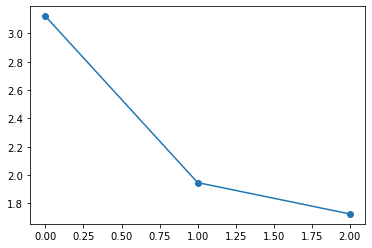

In [28]:
plt.plot(loss_history, "o-")
plt.show()